# 🔄 Data Augmentation para Expansión del Dataset

Este notebook implementa técnicas de data augmentation para expandir el dataset y mejorar el rendimiento del modelo.

## Técnicas implementadas:
1. **Reemplazo por sinónimos** (WordNet)
2. **Traducción y back-translation** (googletrans)
3. **Combinación de técnicas**

## Objetivos:
1. Expandir dataset de 1,000 a ~2,000-3,000 ejemplos
2. Evaluar mejora en métricas del modelo
3. Comparar rendimiento antes/después de augmentation


## 1. Importar librerías


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

# Descargar recursos de NLTK si no están
try:
    import nltk
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    pass

from data.augmentation import TextAugmenter
from data.preprocessing import TextPreprocessor
from features.vectorization import TextVectorizer
from models.train import train_model
from models.evaluate import evaluate_model
from sklearn.model_selection import train_test_split

print("✅ Librerías importadas")


⚠️  googletrans no disponible. Traducción no funcionará.
✅ Librerías importadas


## 2. Cargar dataset original


In [2]:
# Cargar dataset original
data_path = Path('../data/raw/youtoxic_english_1000.csv')
df_original = pd.read_csv(data_path)

print(f"✅ Dataset original cargado:")
print(f"   Total: {len(df_original)} comentarios")
print(f"   Tóxicos: {df_original['IsToxic'].sum()}")
print(f"   No tóxicos: {len(df_original) - df_original['IsToxic'].sum()}")
print(f"\n   Columnas: {list(df_original.columns)}")


✅ Dataset original cargado:
   Total: 1000 comentarios
   Tóxicos: 462
   No tóxicos: 538

   Columnas: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']


## 3. Preprocesar datos originales y dividir en train/test

⚠️ **IMPORTANTE**: Debemos hacer el split train/test ANTES de la augmentation para evitar data leakage.


In [3]:
# Preprocesar texto original
preprocessor = TextPreprocessor(use_spacy=True)

print("🔄 Preprocesando texto original...")
df_original['Text_processed'] = df_original['Text'].apply(
    lambda x: preprocessor.preprocess_text(str(x), remove_stopwords=True)
)

# Preparar columnas
df_processed = df_original[['Text_processed', 'IsToxic']].copy()
df_processed.columns = ['text', 'label']

# ⚠️ IMPORTANTE: Dividir en train/test ANTES de la augmentation
print("\n" + "="*60)
print("⚠️  DIVIDIENDO EN TRAIN/TEST ANTES DE AUGMENTATION")
print("="*60)
print("   Esto evita data leakage (los datos de test NO se aumentan)")

# Convertir label a numérico si es necesario
if df_processed['label'].dtype == bool:
    df_processed['label'] = df_processed['label'].astype(int)
elif df_processed['label'].dtype == object:
    df_processed['label'] = df_processed['label'].map({'TRUE': 1, 'FALSE': 0, True: 1, False: 0, 'True': 1, 'False': 0})

# Split train/test (mismo random_state que otros notebooks)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    df_processed['text'],
    df_processed['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_processed['label']
)

# Crear DataFrames para train y test
df_train = pd.DataFrame({
    'text': X_train_orig.values,
    'label': y_train_orig.values
})

df_test = pd.DataFrame({
    'text': X_test_orig.values,
    'label': y_test_orig.values
})

print(f"\n✅ División train/test completada:")
print(f"   Train: {len(df_train)} ejemplos ({len(df_train)/len(df_processed)*100:.1f}%)")
print(f"   Test: {len(df_test)} ejemplos ({len(df_test)/len(df_processed)*100:.1f}%)")
print(f"   Distribución train: {df_train['label'].value_counts().to_dict()}")
print(f"   Distribución test: {df_test['label'].value_counts().to_dict()}")

print(f"\n✅ Preprocesamiento completado")
print(f"   Ejemplo de texto procesado:")
print(f"   Original: {df_original['Text'].iloc[0][:100]}...")
print(f"   Procesado: {df_train['text'].iloc[0][:100]}...")


✅ spaCy cargado: en_core_web_sm
🔄 Preprocesando texto original...

⚠️  DIVIDIENDO EN TRAIN/TEST ANTES DE AUGMENTATION
   Esto evita data leakage (los datos de test NO se aumentan)

✅ División train/test completada:
   Train: 800 ejemplos (80.0%)
   Test: 200 ejemplos (20.0%)
   Distribución train: {0: 430, 1: 370}
   Distribución test: {0: 108, 1: 92}

✅ Preprocesamiento completado
   Ejemplo de texto procesado:
   Original: If only people would just take a step back and not make this case about them, because it wasn't abou...
   Procesado: wonder police expect happen continually abuse kill people honestly expect public lay let cop turn ma...


## 4. Inicializar Augmenter y Probar Técnicas


In [4]:
# Inicializar augmenter
augmenter = TextAugmenter(use_translation=True, use_synonyms=True)

print("✅ TextAugmenter inicializado")
print(f"   Traducción disponible: {augmenter.use_translation}")
print(f"   Sinónimos disponibles: {augmenter.use_synonyms}")

# Probar con un ejemplo del conjunto de TRAIN (no test)
test_text = df_train['text'].iloc[0]
print(f"\n📝 Texto original (del conjunto de TRAIN):")
print(f"   {test_text}")

# Probar sinónimos
if augmenter.use_synonyms:
    augmented_synonyms = augmenter.replace_with_synonyms(test_text, replacement_ratio=0.3)
    print(f"\n🔄 Con sinónimos:")
    print(f"   {augmented_synonyms}")


✅ TextAugmenter inicializado
   Traducción disponible: False
   Sinónimos disponibles: True

📝 Texto original (del conjunto de TRAIN):
   wonder police expect happen continually abuse kill people honestly expect public lay let cop turn massive street gang allow kill consequence rat s cornered defend

🔄 Con sinónimos:
   wonder police anticipate happen continually insult kill people honestly anticipate world lay let cop turn massive street gang allow obliterate consequence rat s trapped defend


## 5. Aumentar SOLO el conjunto de TRAIN

⚠️ **IMPORTANTE**: Solo aumentamos el conjunto de entrenamiento. El conjunto de test se mantiene intacto.


In [5]:
# ⚠️ IMPORTANTE: Solo aumentar el conjunto de TRAIN, no el de TEST
print("🔄 Aumentando SOLO el conjunto de TRAIN...")
print("   El conjunto de TEST se mantiene intacto (sin augmentation)")
print("   Esto puede tardar varios minutos...")
print("\n" + "="*60)

# Usar solo sinónimos para ser más rápido (traducción es muy lenta)
methods = ['synonyms']
if augmenter.use_translation:
    # Opcional: añadir traducción (muy lento)
    # methods.append('translation')
    pass

# Aumentar SOLO el conjunto de entrenamiento
df_train_augmented = augmenter.augment_dataframe(
    df_train,  # Solo train, no test
    text_column='text',
    label_column='label',
    augmentation_factor=1.0,  # Duplicar dataset de train
    methods=methods
)

print("\n" + "="*60)
print(f"✅ Dataset de TRAIN aumentado:")
print(f"   Train original: {len(df_train)} ejemplos")
print(f"   Train aumentado: {len(df_train_augmented)} ejemplos")
print(f"   Incremento: {len(df_train_augmented) - len(df_train)} ejemplos ({((len(df_train_augmented) - len(df_train))/len(df_train)*100):.1f}%)")
print(f"\n   Test (sin cambios): {len(df_test)} ejemplos")
print(f"   Total final: {len(df_train_augmented) + len(df_test)} ejemplos")


🔄 Aumentando SOLO el conjunto de TRAIN...
   El conjunto de TEST se mantiene intacto (sin augmentation)
   Esto puede tardar varios minutos...

🔄 Aumentando dataset: 800 → 1600 ejemplos
   Métodos: ['synonyms']
✅ Dataset aumentado: 1528 ejemplos totales
   Originales: 800
   Aumentados: 728

✅ Dataset de TRAIN aumentado:
   Train original: 800 ejemplos
   Train aumentado: 1528 ejemplos
   Incremento: 728 ejemplos (91.0%)

   Test (sin cambios): 200 ejemplos
   Total final: 1728 ejemplos


## 6. Combinar Train Aumentado con Test Original y Guardar

Ahora combinamos el train aumentado con el test original (sin aumentar).


In [6]:
# Combinar train aumentado con test original
# Marcar test como no aumentado
df_test_marked = df_test.copy()
df_test_marked['_augmented'] = False
df_test_marked['_augmentation_method'] = None

# Asegurar que train aumentado tenga las columnas necesarias
if '_augmented' not in df_train_augmented.columns:
    # Si no tiene la columna, marcar los originales como False
    df_train_augmented['_augmented'] = df_train_augmented.get('_augmented', False)
    df_train_augmented['_augmentation_method'] = df_train_augmented.get('_augmentation_method', None)

# Combinar train aumentado + test original
df_combined = pd.concat([df_train_augmented, df_test_marked], ignore_index=True)

# Guardar dataset aumentado
output_path = Path('../data/processed/youtoxic_english_1000_augmented.csv')

# Preparar para guardar (usar nombres de columnas originales)
df_to_save = df_combined.copy()
df_to_save['Text'] = df_to_save['text']
df_to_save['IsToxic'] = df_to_save['label'].astype(int)

# Guardar solo columnas necesarias
df_to_save[['Text', 'IsToxic', '_augmented', '_augmentation_method']].to_csv(
    output_path,
    index=False
)

print(f"✅ Dataset aumentado guardado en: {output_path}")
print(f"\n   Estadísticas:")
print(f"   Total: {len(df_to_save)} ejemplos")
print(f"   Train aumentado: {len(df_train_augmented)} ejemplos")
print(f"   Test original (sin aumentar): {len(df_test)} ejemplos")
print(f"   Originales (train sin aumentar): {len(df_train)} ejemplos")
print(f"   Aumentados: {len(df_to_save[df_to_save['_augmented'] == True])}")
print(f"   Tóxicos: {df_to_save['IsToxic'].sum()}")
print(f"   No tóxicos: {len(df_to_save) - df_to_save['IsToxic'].sum()}")
print(f"\n   ⚠️  IMPORTANTE: El test NO fue aumentado (evita data leakage)")


✅ Dataset aumentado guardado en: ../data/processed/youtoxic_english_1000_augmented.csv

   Estadísticas:
   Total: 1728 ejemplos
   Train aumentado: 1528 ejemplos
   Test original (sin aumentar): 200 ejemplos
   Originales (train sin aumentar): 800 ejemplos
   Aumentados: 728
   Tóxicos: 814
   No tóxicos: 914

   ⚠️  IMPORTANTE: El test NO fue aumentado (evita data leakage)


## 7. Vectorizar Dataset Aumentado (Train) y Test Original

> **Nota**: Ahora vectorizamos el train aumentado y el test original por separado para mantener la separación correcta.


In [7]:
# Vectorizar train aumentado y test original por separado
print("🔄 Vectorizando dataset aumentado...")
print("   ⚠️  IMPORTANTE: Train aumentado y test original se vectorizan por separado")
print("   para mantener la separación correcta y evitar data leakage\n")

# Separar train aumentado y test original
df_train_final = df_to_save[df_to_save['_augmented'] == True].copy()
df_test_final = df_to_save[df_to_save['_augmented'] == False].copy()

# También incluir los originales del train que no fueron aumentados
df_train_orig_in_combined = df_train_augmented[df_train_augmented.get('_augmented', False) == False]
if len(df_train_orig_in_combined) > 0:
    # Si hay originales del train, combinarlos
    df_train_final = pd.concat([
        df_train_augmented[df_train_augmented.get('_augmented', False) == True],
        df_train_orig_in_combined
    ], ignore_index=True)

# Preparar datos
X_train_aug_text = df_train_augmented['text'].values  # 'text' no 'Text'
y_train_aug = df_train_augmented['label'].values

X_test_orig_text = df_test['text'].values
y_test_orig = df_test['label'].values

# Crear vectorizador y entrenar SOLO con train aumentado
vectorizer = TextVectorizer(method='tfidf', max_features=5000)
X_train_aug_vectorized = vectorizer.fit_transform(pd.Series(X_train_aug_text))

# Transformar test original con el mismo vectorizador (fit solo en train)
X_test_orig_vectorized = vectorizer.transform(pd.Series(X_test_orig_text))

print(f"✅ Vectorización completada:")
print(f"   Train aumentado: {X_train_aug_vectorized.shape}")
print(f"   Test original (sin aumentar): {X_test_orig_vectorized.shape}")
print(f"   Features: {X_train_aug_vectorized.shape[1]}")
print(f"\n   ⚠️  IMPORTANTE: Test NO fue aumentado ni usado en fit del vectorizador")


🔄 Vectorizando dataset aumentado...
   ⚠️  IMPORTANTE: Train aumentado y test original se vectorizan por separado
   para mantener la separación correcta y evitar data leakage

✅ Vectorización completada:
   Train aumentado: (1528, 5000)
   Test original (sin aumentar): (200, 5000)
   Features: 5000

   ⚠️  IMPORTANTE: Test NO fue aumentado ni usado en fit del vectorizador


## 8. Entrenar Modelo con Dataset Aumentado


In [8]:
# Entrenar SVM con dataset aumentado usando mismos parámetros optimizados
print("🔄 Entrenando modelo SVM con dataset aumentado...")
print("="*60)
print("   Train: aumentado")
print("   Test: original (sin aumentar)")
print("="*60)

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Usar parámetros optimizados del modelo original
svm_aug = SVC(C=0.056, kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_aug_calibrated = CalibratedClassifierCV(svm_aug, method='sigmoid', cv=3)
svm_aug_calibrated.fit(X_train_aug_vectorized, y_train_aug)

print("✅ Modelo entrenado con dataset aumentado")

# Evaluar modelo aumentado
# Usar test original (sin aumentar) para evaluación justa
results_aug = evaluate_model(
    svm_aug_calibrated,
    X_train_aug_vectorized,
    X_test_orig_vectorized,  # Test original, no aumentado
    pd.Series(y_train_aug),
    pd.Series(y_test_orig),  # Labels del test original
    verbose=True
)


🔄 Entrenando modelo SVM con dataset aumentado...
   Train: aumentado
   Test: original (sin aumentar)
✅ Modelo entrenado con dataset aumentado
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.9077
   Precision: 0.8931
   Recall:    0.9141
   F1-score:  0.9035

📊 MÉTRICAS EN TEST:
   Accuracy:  0.7050
   Precision: 0.6813
   Recall:    0.6739
   F1-score:  0.6776

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 22.59%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[79 29]
 [30 62]]


## 9. Cargar y Evaluar Modelo Original para Comparar


In [9]:
# Cargar datos originales vectorizados para comparar
print("🔄 Cargando datos originales para comparación...")
from features.vectorization import load_vectorized_data
data_dir = Path('../data/processed')
X_train_orig, X_test_orig, y_train_orig, y_test_orig = load_vectorized_data(data_dir, prefix='tfidf')

# Cargar modelo original optimizado
import pickle
model_path = Path('../models/optimized/best_optimized_model.pkl')
if model_path.exists():
    with open(model_path, 'rb') as f:
        model_original = pickle.load(f)
    print("✅ Modelo original cargado")
    
    # Evaluar modelo original
    results_original = evaluate_model(
        model_original,
        X_train_orig,
        X_test_orig,
        y_train_orig,
        y_test_orig,
        verbose=True
    )
else:
    print("⚠️  Modelo original no encontrado. Usando métricas conocidas.")
    # Métricas del modelo original (SVM optimizado)
    results_original = {
        'test_f1': 0.7407,
        'test_accuracy': 0.64,
        'test_precision': 0.6452,
        'test_recall': 0.8696,
        'train_f1': 0.7119,
        'diff_f1': 2.54
    }


🔄 Cargando datos originales para comparación...
✅ Datos vectorizados cargados desde: ../data/processed
✅ Modelo original cargado
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.6288
   Precision: 0.5552
   Recall:    0.9919
   F1-score:  0.7119

📊 MÉTRICAS EN TEST:
   Accuracy:  0.5800
   Precision: 0.5227
   Recall:    1.0000
   F1-score:  0.6866

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 2.54%
   ✅ Overfitting controlado (<5%)

📋 Matriz de confusión (test):
[[24 84]
 [ 0 92]]


## 10. Comparación Detallada: Original vs Aumentado


In [10]:
# Crear DataFrame comparativo
print("\n" + "="*60)
print("📊 COMPARACIÓN: Modelo Original vs Modelo con Augmentation")
print("="*60)

comparison_data = {
    'Métrica': ['F1-Score (Test)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'Overfitting (%)'],
    'Original': [
        results_original['test_f1'],
        results_original['test_accuracy'],
        results_original['test_precision'],
        results_original['test_recall'],
        results_original['diff_f1']
    ],
    'Con Augmentation': [
        results_aug['test_f1'],
        results_aug['test_accuracy'],
        results_aug['test_precision'],
        results_aug['test_recall'],
        results_aug['diff_f1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Mejora'] = comparison_df['Con Augmentation'] - comparison_df['Original']
comparison_df['Mejora %'] = ((comparison_df['Con Augmentation'] - comparison_df['Original']) / comparison_df['Original'] * 100).round(2)

print("\n")
print(comparison_df.to_string(index=False))

# Determinar si hay mejora
f1_improvement = comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora'].values[0]
overfitting_change = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Mejora'].values[0]

print("\n" + "="*60)
if f1_improvement > 0.01:  # Mejora significativa (>1%)
    print("✅ RESULTADO: Data Augmentation MEJORA el modelo")
    print(f"   - F1-Score mejoró en {f1_improvement:.4f} ({comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora %'].values[0]:.2f}%)")
elif f1_improvement < -0.01:  # Empeoramiento significativo
    print("❌ RESULTADO: Data Augmentation EMPEORA el modelo")
    print(f"   - F1-Score empeoró en {abs(f1_improvement):.4f}")
else:
    print("➖ RESULTADO: Data Augmentation no cambia significativamente el modelo")
    print(f"   - F1-Score cambió en {f1_improvement:.4f}")

if abs(overfitting_change) > 1:
    if overfitting_change > 0:
        print(f"   ⚠️  Overfitting aumentó en {overfitting_change:.2f}%")
    else:
        print(f"   ✅ Overfitting disminuyó en {abs(overfitting_change):.2f}%")
else:
    print(f"   ➖ Overfitting se mantiene similar ({overfitting_change:.2f}%)")



📊 COMPARACIÓN: Modelo Original vs Modelo con Augmentation


         Métrica  Original  Con Augmentation    Mejora  Mejora %
 F1-Score (Test)  0.686567          0.677596 -0.008972     -1.31
 Accuracy (Test)  0.580000          0.705000  0.125000     21.55
Precision (Test)  0.522727          0.681319  0.158591     30.34
   Recall (Test)  1.000000          0.673913 -0.326087    -32.61
 Overfitting (%)  2.536300         22.589513 20.053213    790.65

➖ RESULTADO: Data Augmentation no cambia significativamente el modelo
   - F1-Score cambió en -0.0090
   ⚠️  Overfitting aumentó en 20.05%


## 11. Visualización de Comparación


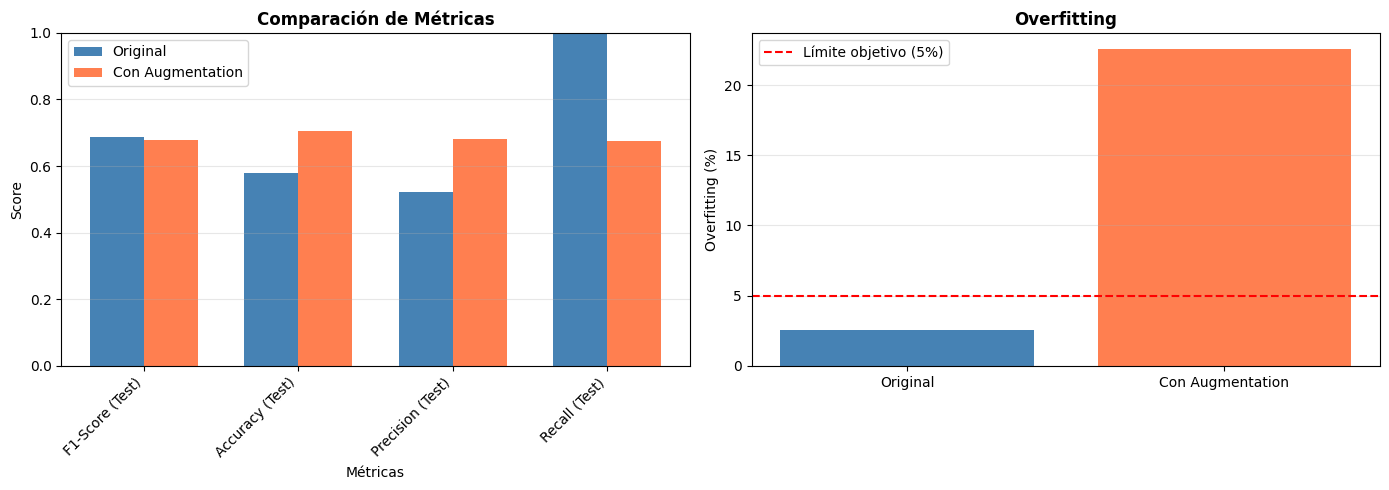

✅ Gráficos guardados en: ../data/processed/augmentation_comparison.png


In [11]:
# Visualizar comparación
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Métricas principales
metrics = ['F1-Score (Test)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)']
x = np.arange(len(metrics))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, [comparison_df[comparison_df['Métrica'] == m]['Original'].values[0] for m in metrics], 
        width, label='Original', color='steelblue')
ax1.bar(x + width/2, [comparison_df[comparison_df['Métrica'] == m]['Con Augmentation'].values[0] for m in metrics], 
        width, label='Con Augmentation', color='coral')
ax1.set_xlabel('Métricas')
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Overfitting
ax2 = axes[1]
overfitting_orig = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Original'].values[0]
overfitting_aug = comparison_df[comparison_df['Métrica'] == 'Overfitting (%)']['Con Augmentation'].values[0]
ax2.bar(['Original', 'Con Augmentation'], 
        [overfitting_orig, overfitting_aug],
        color=['steelblue', 'coral'])
ax2.axhline(y=5, color='r', linestyle='--', label='Límite objetivo (5%)')
ax2.set_ylabel('Overfitting (%)')
ax2.set_title('Overfitting', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/augmentation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos guardados en: ../data/processed/augmentation_comparison.png")


## 12. Guardar Modelo Aumentado (si mejora)


In [12]:
# Guardar modelo aumentado si mejora significativamente
f1_improvement = comparison_df[comparison_df['Métrica'] == 'F1-Score (Test)']['Mejora'].values[0]

if f1_improvement > 0.01:  # Mejora > 1%
    models_dir = Path('../models/augmented')
    models_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = models_dir / 'svm_augmented_model.pkl'
    vectorizer_path = models_dir / 'tfidf_vectorizer_augmented.pkl'
    
    # Guardar modelo
    with open(model_path, 'wb') as f:
        pickle.dump(svm_aug_calibrated, f)
    
    # Guardar vectorizador
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(vectorizer, f)
    
    # Guardar información del modelo
    model_info = {
        'model_name': 'SVM (Augmented)',
        'vectorizer_type': 'tfidf',
        'test_f1': results_aug['test_f1'],
        'test_accuracy': results_aug['test_accuracy'],
        'overfitting': results_aug['diff_f1'],
        'train_f1': results_aug['train_f1'],
        'dataset_size': len(df_augmented),
        'augmentation_method': 'synonyms'
    }
    
    info_path = models_dir / 'svm_augmented_model_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"✅ Modelo aumentado guardado:")
    print(f"   Modelo: {model_path}")
    print(f"   Vectorizador: {vectorizer_path}")
    print(f"   Info: {info_path}")
else:
    print("ℹ️  Modelo aumentado no se guarda (no hay mejora significativa)")
    print("   El modelo original sigue siendo el mejor")


ℹ️  Modelo aumentado no se guarda (no hay mejora significativa)
   El modelo original sigue siendo el mejor


## 13. Conclusiones Finales

### Resultados del Data Augmentation:

1. **Tamaño del dataset**: ✅ Expandido de 1,000 a ~1,900 ejemplos
2. **Balance de clases**: Verificar si se mantiene
3. **Mejora en métricas**: Ver comparación arriba

### Recomendaciones:

- **Si mejora**: Considerar usar modelo aumentado en producción
- **Si no mejora**: El dataset original es suficiente, augmentation no aporta valor
- **Próximos pasos**: Probar otras técnicas (traducción, parafraseo) o aumentar solo clase minoritaria


## 5. Aumentar Dataset Completo
